<a href="https://colab.research.google.com/github/eliabrodsky/bioml_georgetown/blob/main/Arthritis_Feature_Selection_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Three multi-center genome-wide transcriptomic data sets (Affymetrix HG-U133 A/B) from a total of 79 individuals, including 20 healthy controls (control group - CG), as well as 26 osteoarthritis (OA) and 33 RA patients

*Woetzel D, Huber R, Kupfer P, et al. Identification of rheumatoid arthritis and osteoarthritis patients by transcriptome-based rule set generation. Arthritis Res Ther. 2014;16(2):R84. Published 2014 Apr 1. doi:10.1186/ar4526*

https://pubmed.ncbi.nlm.nih.gov/24690414/


# Set up the Notebook

In [1]:
!pip install -U kaleido -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 66 kB/s 


In [2]:
#import pandas and numpy
import pandas as pd
import numpy as np

#PCA
from sklearn.decomposition import PCA 

#import standard classification tools from sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import itertools

#classification model
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

template = 'ggplot2'

# Import and Prepare Data

In [38]:
#load data
data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/arthritis_annotated.csv',sep=',',header=(0))
features = data.iloc[1:, 0].values

#add the gene id to index column
data.index = data.ID

#drop or remove "id" column from the data
data=data.drop(['ID'], axis = 1) 

#transpose
dataT = np.transpose(data)

#prepare train and test data
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

#save class names
classes = np.unique(y)
n_classes = len(classes)
cat = dataT['Type']

#prepare train and test data (try changing test_size, enable/disable stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=0, stratify = y)

#print out test class proportion from total
for i in range(len(classes)):
  print(classes[i], y_test.tolist().count(classes[i]), "/", y.tolist().count(classes[i]))

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.



Norm 4 / 10
OA 3 / 10
RA 5 / 13


In [33]:
dataT = dataT.drop(columns=['Type'])
dataT.head()

ID,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,THRA,PTPN21,CCL5,CYP2E1,...,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?,#NAME?
GSM1337304,455.2,130.5,385,696.6,27.9,651.7,101,85.6,360.9,86.5,...,32.6,71.9,15378.4,13521.3,5.6,5.7,11.2,2.2,26.9,4.3
GSM1337305,380.9,164.6,607.4,1049.8,38,722.1,78.7,13.6,207.4,58.5,...,65.8,137.6,19097.7,17321.2,9.6,10.0,3.7,17.1,7.7,4.7
GSM1337306,1045.9,179.7,216.3,1069.1,54.1,531.1,96.6,35.6,30.5,20.9,...,65.0,88.1,16515.9,16268.3,4.8,9.2,11.9,2.6,5.8,5.3
GSM1337307,267.2,230.9,432.9,1226.6,60.5,247.6,80.3,34,10,58.3,...,23.0,88.9,12917.0,11782.7,7.5,7.8,6.2,1.9,15.7,20.8
GSM1337308,403.2,172.6,416.1,1107.5,58.9,318.1,95.2,15.2,495.6,36,...,111.0,173.5,12947.2,11271.1,8.8,21.5,16.1,2.1,9.9,11.2


In [34]:
!pip install -U kaleido --q

In [35]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

scaled = StandardScaler() 
scaled.fit(dataT) 
scaled_data = scaled.transform(dataT) 

#Run Principal Component Analysis
pca = PCA(n_components=3) 

pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Class", color=cat,
                       template="plotly_white", height=800, width=800)

#to save as image (and for github): figPCA.show('svg')
figPCA.show()

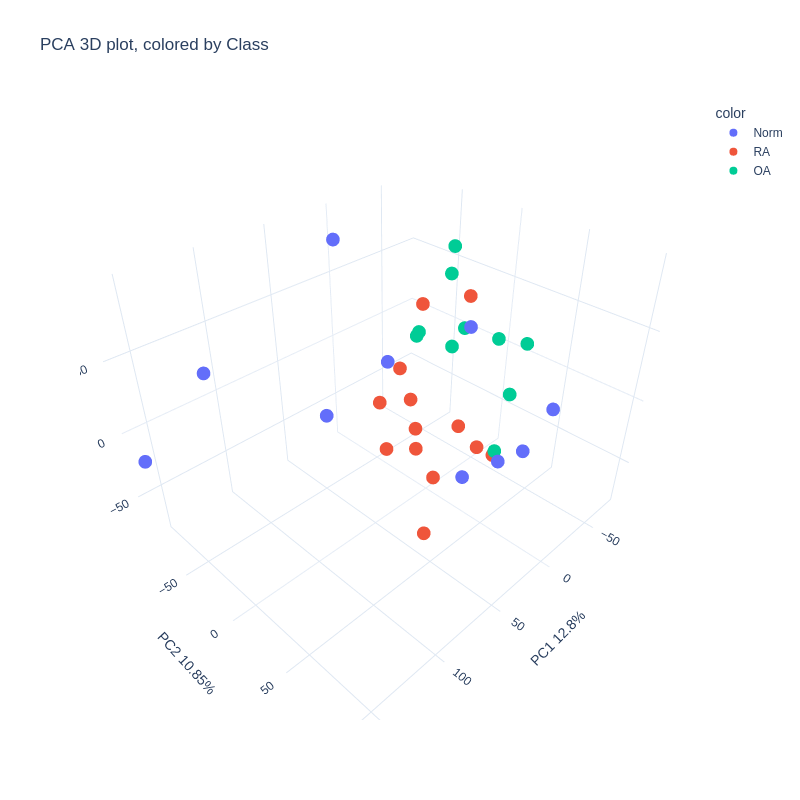

In [36]:
from IPython.display import Image

img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)
Image(img_bytes)

# Random Forest

In [39]:
#define Random forest model
model = RandomForestClassifier(n_estimators = 100, 
                               max_depth = 500, 
                               verbose=False,
                               random_state=0)

#fit model on training data
model.fit(X_train, y_train)

#Predict test data
predictions = model.predict(X_test)
print("Model accuracy = ", accuracy_score(y_test, predictions))

Model accuracy =  0.9166666666666666


In [40]:
#define Random forest model
model = RandomForestClassifier(n_estimators = 1000, 
                               max_depth = 5000,
                               bootstrap=True, 
                               verbose=False,
                               random_state=0)

#fit model on training data
model.fit(X_train, y_train)

#Predict test data
predictions = model.predict(X_test)
print("Model accuracy = ", accuracy_score(y_test, predictions))

Model accuracy =  0.9166666666666666


## Confusion Matrix

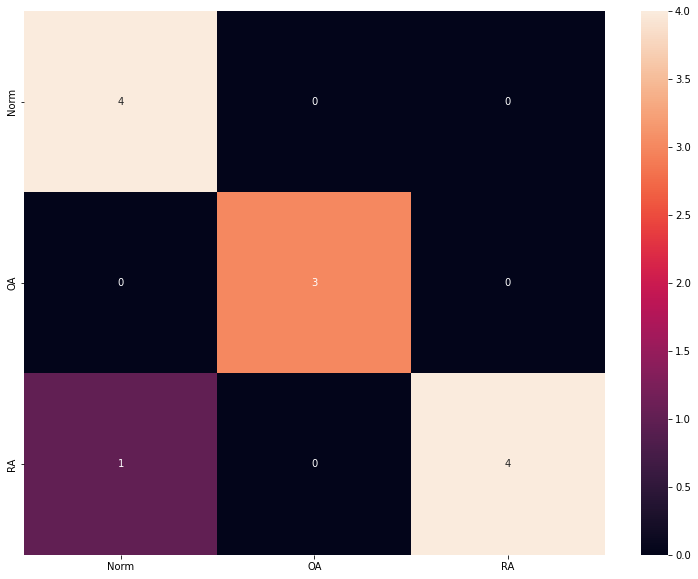

In [41]:
#prepare a confusion matrix
conf = confusion_matrix(y_test,predictions)
new_conf = pd.DataFrame(conf, columns=classes, index=classes)

#plot heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(new_conf, annot=True);

##Feature Importance

total number of selected features:  14


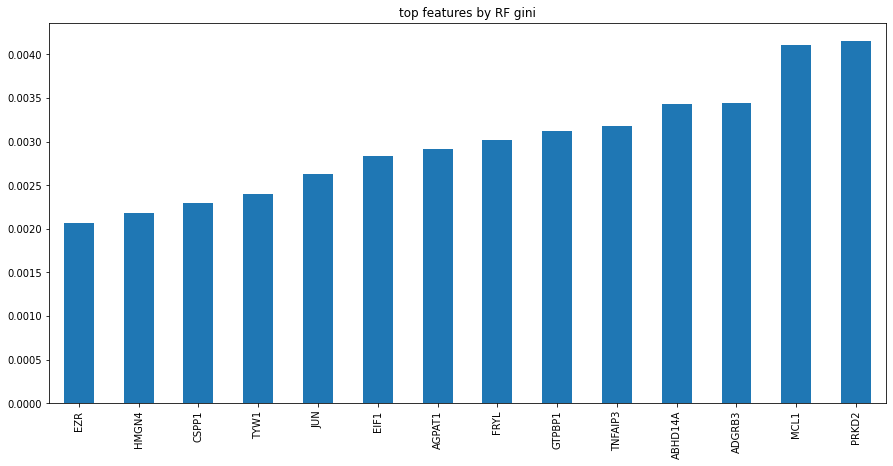

In [42]:
#prepare the list of significant features
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

#select top features and save them
forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances[forest_importances > 0.002]
forest_importances = forest_importances.sort_values()

#plot forest_importances
forest_importances.plot.bar(figsize=(15, 7), title="top features by RF gini");

#print
print("total number of selected features: ", len(forest_importances))

# PCA after feature selection


In [43]:
selected_features = forest_importances.index.tolist()

dataT1 = dataT[dataT.columns.intersection(selected_features)]
print("new dimensions of select features: ", dataT1.shape)

#Run Principal Component Analysis
pca = PCA(n_components=3) 
pca.fit(dataT1) 
xpca = pca.transform(dataT1)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio_[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio_[1]),2)) 
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio_[2]),2))

#create dataframe for PCA
df_pca = pd.DataFrame(xpca)
df_pca.columns = [PC1_label,PC2_label,PC3_label]

#visualize
figPCA = px.scatter_3d(df_pca, x=PC1_label, y=PC2_label, z=PC3_label, 
                       title="PCA 3D plot, colored by Class", color=cat,
                       template="plotly_white", height=600, width=800)
figPCA.show()

new dimensions of select features:  (33, 41)


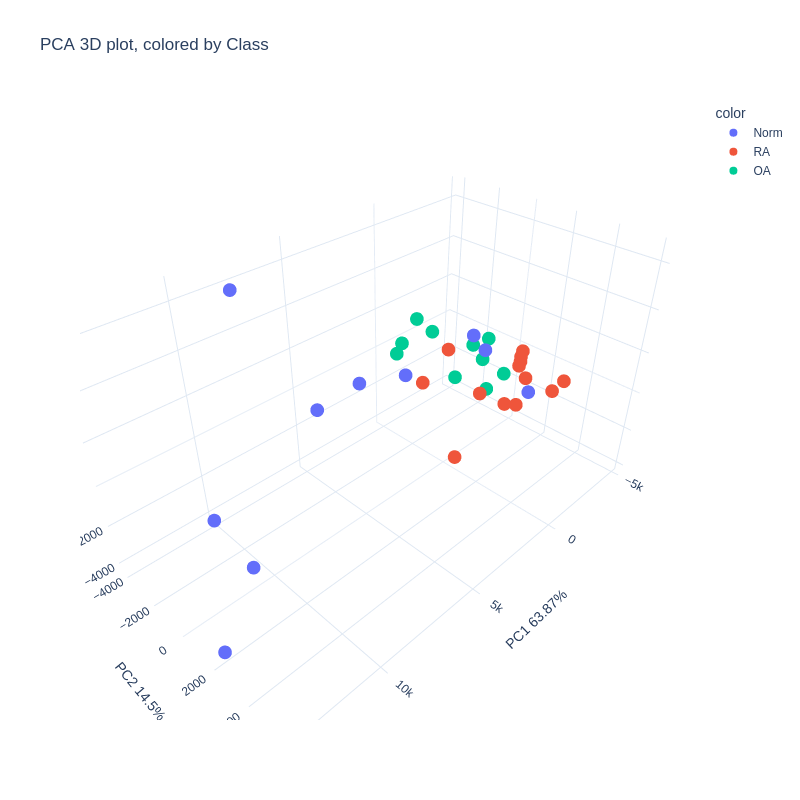

In [44]:
img_bytes = figPCA.to_image(format="png", width=800, height=800, scale=1)
Image(img_bytes)

# Other Classification Models

In [49]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from scipy.stats import uniform

#Compare Models
model = [LogisticRegression(max_iter=500, random_state=0), 
         LinearSVC(C = 0.1, dual=True, random_state=0), 
         SVC(kernel='poly', gamma='auto', class_weight='balanced', coef0=1.5),
         SGDClassifier(max_iter=500, learning_rate = 'adaptive', eta0 = 4, random_state=0),
         Perceptron(tol=1e-3, random_state=0),
         MLPClassifier(random_state=1, max_iter = 10000, solver ='adam'),
         HistGradientBoostingClassifier(max_iter = 10000, max_depth = 5, learning_rate = 0.001)]

model_name = []

for i in range(0,len(model)): model[i].fit(X_train, y_train);
for j in range(0,len(model)): model_name.append(str(model[j])[:15])

# after training we can predict labels for the test samples
for i in range(0,len(model)):
   
  result = ("Classification Score for TRAIN data using ", model_name[i], "... is ", round(model[i].score(X_train, y_train),2))
  result = ''.join(str(x) for x in result)
  print(result)

print("-----------------------")

for i in range(0,len(model)):
  result = ("Classification Score for TEST data using ", model_name[i], "... is ", round(model[i].score(X_test, y_test),2))
  result = ''.join(str(x) for x in result)
  print(result)

Classification Score for TRAIN data using LogisticRegress... is 1.0
Classification Score for TRAIN data using LinearSVC(C=0.1... is 1.0
Classification Score for TRAIN data using SVC(class_weigh... is 1.0
Classification Score for TRAIN data using SGDClassifier(e... is 1.0
Classification Score for TRAIN data using Perceptron()... is 1.0
Classification Score for TRAIN data using MLPClassifier(m... is 1.0
Classification Score for TRAIN data using HistGradientBoo... is 0.38
-----------------------
Classification Score for TEST data using LogisticRegress... is 1.0
Classification Score for TEST data using LinearSVC(C=0.1... is 1.0
Classification Score for TEST data using SVC(class_weigh... is 0.83
Classification Score for TEST data using SGDClassifier(e... is 0.92
Classification Score for TEST data using Perceptron()... is 0.92
Classification Score for TEST data using MLPClassifier(m... is 0.92
Classification Score for TEST data using HistGradientBoo... is 0.42


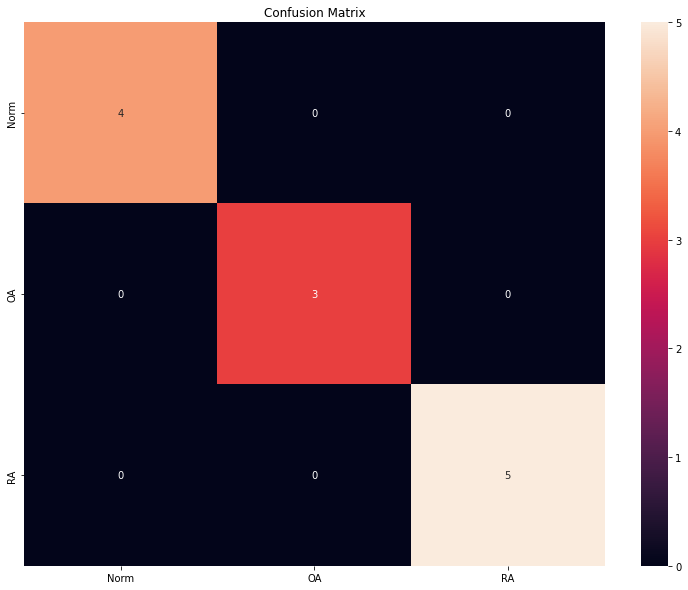

In [59]:
predictions = model[0].predict(X_test)

#prepare a confusion matrix
conf = confusion_matrix(y_test,predictions)
new_conf = pd.DataFrame(conf, columns=classes, index=classes)

import matplotlib.pyplot as plt
import seaborn as sns

#plot heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(new_conf, annot=True);
ax.set_title('Confusion Matrix');

In [60]:
len(model[0].coef_)

3

In [68]:
importance = np.abs(model[1].coef_)
feature_names = np.array(features)

result_df = pd.DataFrame(model[1].coef_)
result_df.columns = feature_names 
result_df = result_df.T
result_df.head()

,0,1,2
MIR4640,-1.774227e-07,1.360864e-07,-4.503826e-08
RFC2,2.390772e-08,-1.953740e-08,-1.070925e-08
HSPA6,-1.184794e-07,-3.547039e-08,1.484454e-07
PAX8,-1.154634e-07,-3.522214e-09,1.045473e-08
GUCA1A,-1.504363e-07,2.447233e-07,-1.402867e-07
